## Here, we used new training data that has randomized dispersions and phases to try and predict the dispersion as well as the phase.


In [4]:
#Load packages
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.api as sm

from sklearn import datasets
from sklearn import linear_model
from sklearn.model_selection import train_test_split

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import *

from sklearn.multioutput import MultiOutputRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler  



## This function will plot the true vs. predicted with various line fits
def plotSummary(true, predicted, name):
    #from pylab import *
    #import numpy as np
    #import matplotlib.pyplot as plt
    
    figure()
    plt.scatter(true,predicted, alpha = 0.2)
    
    plt.title(name)
    plt.xlabel('True')
    plt.ylabel('Predicted')

    xmin, xmax = plt.xlim()
    plt.plot([xmin,xmax], [xmin,xmax], c='r', linewidth = 2)  #line with slope of one

    fit_temp = np.polyfit(true, predicted,1)
    xp = np.linspace(xmin, xmax, 100)
    p = np.poly1d(fit_temp)
    plt.plot(xp, p(xp), '-', color = 'black')
    
    print(' ')
    print('RMSE on test data:', np.sqrt(mean_squared_error(true, predicted)), 'for ', name)
    print('R^2 Score on test data:', r2_score(true, predicted), 'for', name)

    
    return

def myResiduals(testY, predictY):
    ## residuals 1
    i = 0 # resetting i
    iterations = len(testY) # gets number of dots/points
    residual_sum = 0 # initializes sum of residuals
    for i in range (0,iterations): # for every dot/point
       ys = testY # get ys of testing data
       ys = ys.values # take out indexing, data types, names
       y = ys[i]
       predict_ys = predictY.values # get ys of all dots/points
       predict_y = predict_ys[i] # get the y value of the dot/point at specfic x value i
       diff = y - predict_y # find the difference in height
       diff = abs(diff) # take the absolute value
       residual_sum = diff + residual_sum # add specific residual sum at i to sum of residuals
    residual_average = residual_sum/iterations # find the average of the residuals
    print('The average residual for predict:', round(residual_average,4)) # display average of residuals

    minY = min(ys) # find the minimum y value for testing data
    maxY = max(ys) # find the max y value for testing data
    minpredict = min(predictY) # find the min y value for the prediction data
    maxpredict = max(predictY) # find the max y value for the prediction data
    #print('minY', minY, 'maxY', maxY)
    #print('minpredict', minpredict, 'maxpredict', maxpredict)
    rangeY = minY + maxY # find the range of the testing data
    rangepredict = minpredict - maxpredict # find the range of the predictions
    #print('rangeY', rangeY)
    #print('rangepredict', rangepredict)
    residual_percent_rangepredict = (residual_average/abs(rangepredict))*100 # calculate what percent the residual is of the range
    print('Residual is this percent of predict range', round(residual_percent_rangepredict,3), '%')
    
    return
    

## Made new training data with E_0 fixed. 

In [5]:
#Load the training data


peak_names = ['peak1', 'peak2', 'peak3', 'peak4']
locs_names = ['loc1', 'loc2', 'loc3', 'loc4']
width_names = ['width1', 'width2', 'width3','width4']
prom_names = ['prom1', 'prom2', 'prom3', 'prom4']

energy = (pd.read_csv('Training_Data/Hexagon/HexagonBias_v4.csv', header=None)*1000).round().astype(int)
energy_names = ['E_%i_mV' % item for item in list(energy.T[0])]

col_names2 = ['deltaI', 'deltaR', 'E_0', 'mstar', 'alpha']+ peak_names + locs_names + width_names + prom_names

col_names1 = ['deltaI', 'deltaR', 'E_0', 'mstar', 'alpha'] + energy_names

data1 = pd.read_csv('Training_Data/Hexagon/HexagonTrainingData062818_v10_E0fixed_specPoints.csv', header = None, names = col_names1)
data2 = pd.read_csv('Training_Data/Hexagon/HexagonTrainingData062818_v10_E0fixed_peakinfo.csv', header = None, names = col_names2)

# Since E_0 is fixed don't include that

X3 = data1.drop(['deltaI', 'deltaR', 'E_0', 'mstar', 'alpha'], axis = 1)
Y3 = data1[['deltaI', 'deltaR', 'mstar', 'alpha']]

X4 = data2.drop(['deltaI', 'deltaR', 'E_0', 'mstar', 'alpha'], axis = 1)
Y4 = data2[['deltaI', 'deltaR', 'mstar', 'alpha']]

ts1 = 0.3
rs1 = 42

X3_train, X3_test, Y3_train, Y3_test = train_test_split(X3, Y3, test_size = ts1, random_state = rs1)
X4_train, X4_test, Y4_train, Y4_test = train_test_split(X4, Y4, test_size = ts1, random_state = rs1)

data1.head()

,deltaI,deltaR,E_0,mstar,alpha,E_-400_mV,E_-398_mV,E_-396_mV,E_-394_mV,E_-392_mV,...,E_482_mV,E_484_mV,E_486_mV,E_488_mV,E_490_mV,E_492_mV,E_494_mV,E_496_mV,E_498_mV,E_500_mV
0,0.81472,-0.147980,0.4473,0.43701,-8.6764,0.161980,0.176570,0.195840,0.221070,0.254360,...,0.81019,0.83237,0.85556,0.87910,0.90359,0.92774,0.95222,0.97615,1.00000,1.02340
1,0.09754,-1.133300,0.4473,0.44363,-5.3511,0.032621,0.036163,0.040247,0.045382,0.053563,...,0.11992,0.12054,0.12151,0.12320,0.12550,0.12805,0.13144,0.13622,0.14126,0.14672
2,0.15761,-0.046193,0.4473,0.37281,-6.9972,0.360170,0.373990,0.392560,0.416620,0.446940,...,1.06200,1.05860,1.05550,1.05250,1.04960,1.04720,1.04470,1.04240,1.04020,1.03840
3,0.14189,-0.908300,0.4473,0.41883,-5.4051,0.033656,0.036668,0.039938,0.044134,0.050066,...,0.46875,0.41733,0.37527,0.34107,0.31138,0.28706,0.26659,0.24842,0.23363,0.22098
4,0.65574,-1.514700,0.4473,0.44010,-8.2126,0.088861,0.096974,0.107550,0.121530,0.140090,...,0.56134,0.58892,0.61955,0.65425,0.69306,0.73552,0.78145,0.83063,0.88168,0.93441


### E0 Fixed Models

 
RMSE on test data: 2.4354897049941466 for  Delta I
R^2 Score on test data: -69.64587160544839 for Delta I
 
RMSE on test data: 2.0841656977677254 for  Delta R
R^2 Score on test data: -20.503855497630394 for Delta R
 
RMSE on test data: 2.0841656977677254 for  Delta R Zoomed In
R^2 Score on test data: -20.503855497630394 for Delta R Zoomed In
 
RMSE on test data: 0.06034572277043005 for  m star
R^2 Score on test data: -0.9144370970850586 for m star
 
RMSE on test data: 30.29230215347882 for  alpha
R^2 Score on test data: -110.14001570874423 for alpha
 
RMSE on test data: 0.1744747609391783 for  Delta I
R^2 Score on test data: 0.6374403947508118 for Delta I
 
RMSE on test data: 0.30061137186138825 for  Delta R
R^2 Score on test data: 0.5526343275276662 for Delta R
 
RMSE on test data: 0.016161005938267498 for  mstar
R^2 Score on test data: 0.8626954609838009 for mstar
 
RMSE on test data: 2.617964954570027 for  alpha
R^2 Score on test data: 0.1698940041307938 for alpha


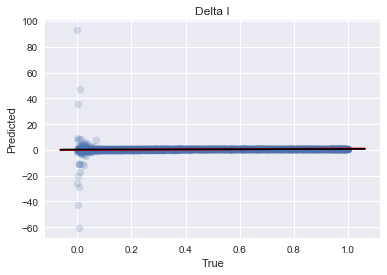

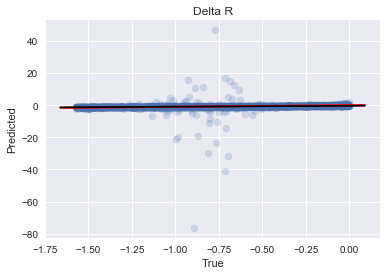

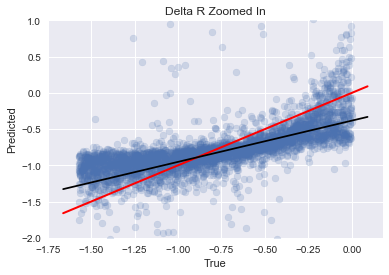

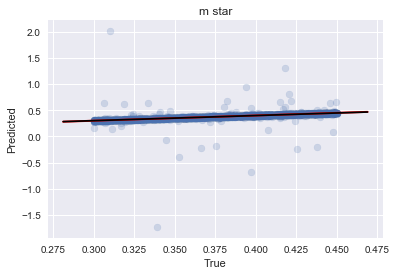

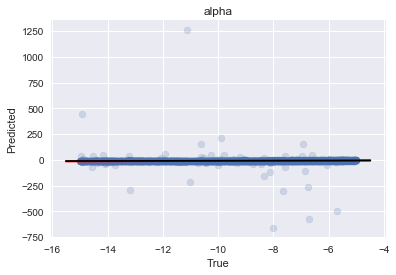

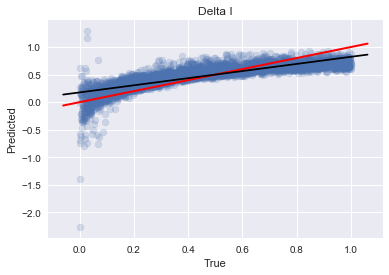

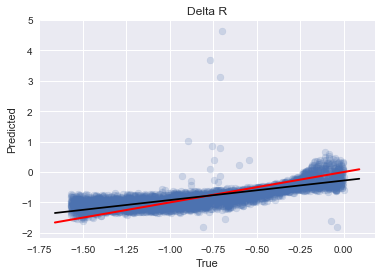

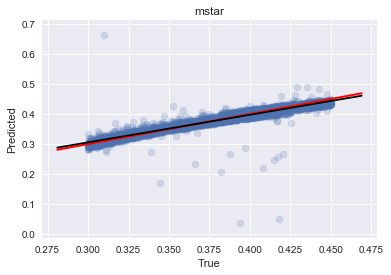

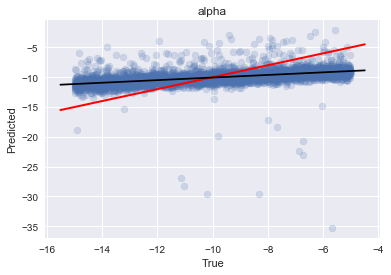

In [15]:
#Initialize and fit OLS model for deltaI 
E0_model_OLS_I_sp = sm.OLS(Y3_train['deltaI'], X3_train)
E0_model_OLS_R_sp = sm.OLS(Y3_train['deltaR'], X3_train)
E0_model_OLS_mstar_sp = sm.OLS(Y3_train['mstar'], X3_train)
E0_model_OLS_alpha_sp = sm.OLS(Y3_train['alpha'], X3_train)

E0_results_OLS_I_sp = E0_model_OLS_I_sp.fit()
E0_results_OLS_R_sp = E0_model_OLS_R_sp.fit()
E0_results_OLS_mstar_sp = E0_model_OLS_mstar_sp.fit()
E0_results_OLS_alpha_sp = E0_model_OLS_alpha_sp.fit()

#Make predictions on testing data
E0_predictions_OLS_I_sp = E0_results_OLS_I_sp.predict(X3_test) # make the predictions by the model
E0_predictions_OLS_R_sp = E0_results_OLS_R_sp.predict(X3_test)
E0_predictions_OLS_mstar_sp = E0_results_OLS_mstar_sp.predict(X3_test)
E0_predictions_OLS_alpha_sp = E0_results_OLS_alpha_sp.predict(X3_test)

E0_scores_OLS = [r2_score(Y3_test['deltaI'], E0_predictions_OLS_I_sp), 
                 r2_score(Y3_test['deltaR'], E0_predictions_OLS_R_sp),  
                 r2_score(Y3_test['mstar'], E0_predictions_OLS_mstar_sp),
                 r2_score(Y3_test['alpha'], E0_predictions_OLS_alpha_sp) ]

#If we plot the predictions against the test data, a perfect model should be linear

plotSummary(Y3_test['deltaI'], E0_predictions_OLS_I_sp,'Delta I')
#ylim([-1,5])
plotSummary(Y3_test['deltaR'], E0_predictions_OLS_R_sp, 'Delta R')
plotSummary(Y3_test['deltaR'], E0_predictions_OLS_R_sp, 'Delta R Zoomed In')
ylim([-2,1])
plotSummary(Y3_test['mstar'], E0_predictions_OLS_mstar_sp, 'm star')
plotSummary(Y3_test['alpha'], E0_predictions_OLS_alpha_sp, 'alpha')

#Initialize and fit OLS model for deltaI 
E0_model_OLS_I_pi = sm.OLS(Y4_train['deltaI'], X4_train)
E0_model_OLS_R_pi = sm.OLS(Y4_train['deltaR'], X4_train)
E0_model_OLS_mstar_pi = sm.OLS(Y4_train['mstar'], X4_train)
E0_model_OLS_alpha_pi = sm.OLS(Y4_train['alpha'], X4_train)

E0_results_OLS_I_pi = E0_model_OLS_I_pi.fit()
E0_results_OLS_R_pi = E0_model_OLS_R_pi.fit()
E0_results_OLS_mstar_pi = E0_model_OLS_mstar_pi.fit()
E0_results_OLS_alpha_pi = E0_model_OLS_alpha_pi.fit()

#Make predictions on testing data
E0_predictions_OLS_I_pi = E0_results_OLS_I_pi.predict(X4_test) # make the predictions by the model
E0_predictions_OLS_R_pi = E0_results_OLS_R_pi.predict(X4_test)
E0_predictions_OLS_mstar_pi = E0_results_OLS_mstar_pi.predict(X4_test)
E0_predictions_OLS_alpha_pi = E0_results_OLS_alpha_pi.predict(X4_test)

E0_scores_OLS_pi = [r2_score(Y4_test['deltaI'], E0_predictions_OLS_I_pi), 
                 r2_score(Y4_test['deltaR'], E0_predictions_OLS_R_pi), 
                 r2_score(Y4_test['mstar'], E0_predictions_OLS_mstar_pi), 
                 r2_score(Y4_test['alpha'], E0_predictions_OLS_alpha_pi)]

#If we plot the predictions against the test data, a perfect model should be linear

plotSummary(Y4_test['deltaI'], E0_predictions_OLS_I_pi,'Delta I')
#ylim([-1,5])
plotSummary(Y4_test['deltaR'], E0_predictions_OLS_R_pi, 'Delta R')

plotSummary(Y4_test['mstar'], E0_predictions_OLS_mstar_pi, 'mstar')
plotSummary(Y4_test['alpha'], E0_predictions_OLS_alpha_pi, 'alpha')


 
RMSE on test data: 0.21037168457560154 for  deltaI Depth 60
R^2 Score on test data: 0.4729051648600442 for deltaI Depth 60
 
RMSE on test data: 0.30445296596554594 for  deltaR Depth 60
R^2 Score on test data: 0.5411272542633696 for deltaR Depth 60
 
RMSE on test data: 0.013457626815189727 for  mstar
R^2 Score on test data: 0.9047894493983728 for mstar
 
RMSE on test data: 1.3815998182965195 for  alpha
R^2 Score on test data: 0.7688092634782097 for alpha
 
RMSE on test data: 0.20018055042234129 for  deltaI Depth 60
R^2 Score on test data: 0.5227367991616306 for deltaI Depth 60
 
RMSE on test data: 0.3083861221230117 for  deltaR Depth 60
R^2 Score on test data: 0.5291945330956493 for deltaR Depth 60
 
RMSE on test data: 0.009454526360091912 for  mstar DT pi
R^2 Score on test data: 0.9530075953626831 for mstar DT pi
 
RMSE on test data: 1.52366480836575 for  alpha
R^2 Score on test data: 0.7188197793180044 for alpha


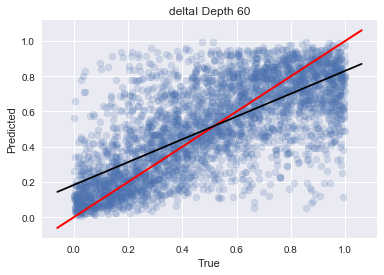

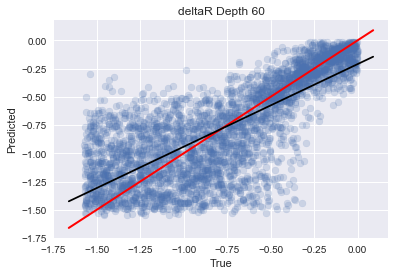

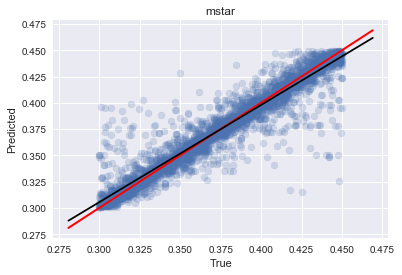

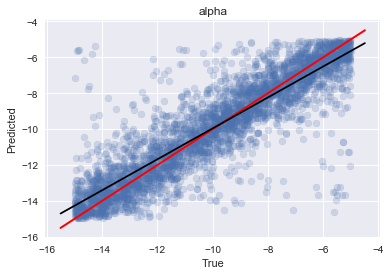

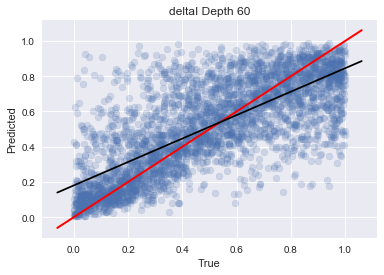

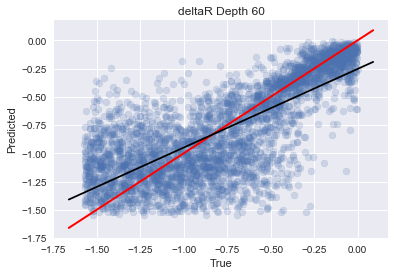

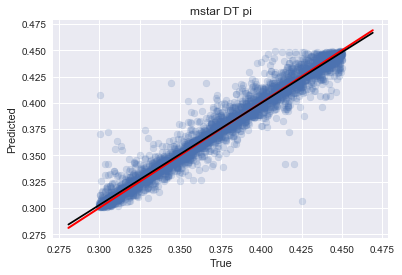

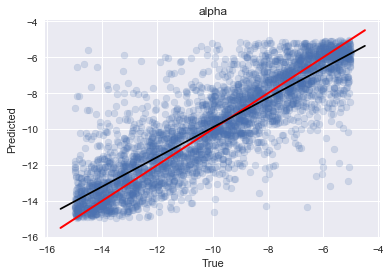

In [7]:
#Initialize the model
rs = 42
E0_regr_DT_sp = DecisionTreeRegressor(max_depth=60, min_samples_leaf = 2, random_state = rs)

#Fit the model
E0_regr_DT_sp = E0_regr_DT_sp.fit(X3_train, Y3_train)


#Use model to predict
E0_predictions_DT_sp = E0_regr_DT_sp.predict(X3_test)

E0_scores_DT = [r2_score(Y3_test['deltaI'], E0_predictions_DT_sp[:,0]), 
                r2_score(Y3_test['deltaR'], E0_predictions_DT_sp[:,1]), 
                r2_score(Y3_test['mstar'], E0_predictions_DT_sp[:,2]), 
                r2_score(Y3_test['alpha'], E0_predictions_DT_sp[:,3]) ]

#Plot results
plotSummary(Y3_test['deltaI'], E0_predictions_DT_sp[:,0], 'deltaI Depth 60')
#myResiduals(Y_test['deltaI'], y_3[:,0])
plotSummary(Y3_test['deltaR'], E0_predictions_DT_sp[:,1], 'deltaR Depth 60')
#myResiduals(Y_test['deltaR'], y_3[:,1])
plotSummary(Y3_test['mstar'], E0_predictions_DT_sp[:,2], 'mstar')
plotSummary(Y3_test['alpha'], E0_predictions_DT_sp[:,3], 'alpha')


#Initialize the model
rs = 42
E0_regr_DT_pi = DecisionTreeRegressor(max_depth=60, min_samples_leaf = 2, random_state = rs)

#Fit the model
E0_regr_DT_pi.fit(X4_train, Y4_train)


#print(data1[data1['Regr - DT']>0.001])

#Use model to predict
E0_predictions_DT_pi = E0_regr_DT_pi.predict(X4_test)

E0_scores_DT_pi = [r2_score(Y4_test['deltaI'], E0_predictions_DT_pi[:,0]), 
                r2_score(Y4_test['deltaR'], E0_predictions_DT_pi[:,1]), 
                r2_score(Y4_test['mstar'], E0_predictions_DT_pi[:,2]), 
                r2_score(Y4_test['alpha'], E0_predictions_DT_pi[:,3])]

#Plot results
plotSummary(Y4_test['deltaI'], E0_predictions_DT_pi[:,0], 'deltaI Depth 60')
#myResiduals(Y_test['deltaI'], y_3[:,0])
plotSummary(Y4_test['deltaR'], E0_predictions_DT_pi[:,1], 'deltaR Depth 60')
#myResiduals(Y_test['deltaR'], y_3[:,1])

plotSummary(Y4_test['mstar'], E0_predictions_DT_pi[:,2], 'mstar DT pi')
plotSummary(Y4_test['alpha'], E0_predictions_DT_pi[:,3], 'alpha')


Score - Random Forest: 0.9015409711264196 for delta I/R 10
 
RMSE on test data: 0.1452508227431088 for  deltaI 10
R^2 Score on test data: 0.7487237781066397 for deltaI 10
 
RMSE on test data: 0.22321247562757646 for  deltaR 10
R^2 Score on test data: 0.7533456529769178 for deltaR 10
 
RMSE on test data: 0.007285899430527383 for  mstar
R^2 Score on test data: 0.9720929160259815 for mstar
 
RMSE on test data: 0.8776625194525545 for  alpha
R^2 Score on test data: 0.9067044352223872 for alpha
 
RMSE on test data: 0.15025788960859288 for  deltaI 10
R^2 Score on test data: 0.7311012637897575 for deltaI 10
 
RMSE on test data: 0.24631706285719693 for  deltaR 10
R^2 Score on test data: 0.6996408684041179 for deltaR 10
 
RMSE on test data: 0.006946778702911872 for  mstar
R^2 Score on test data: 0.9746303168592153 for mstar
 
RMSE on test data: 1.15920448010162 for  alpha
R^2 Score on test data: 0.8372481269043547 for alpha


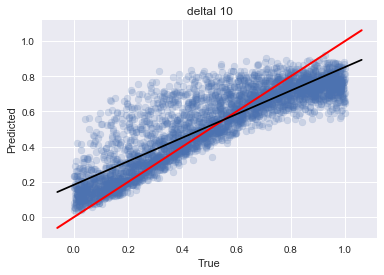

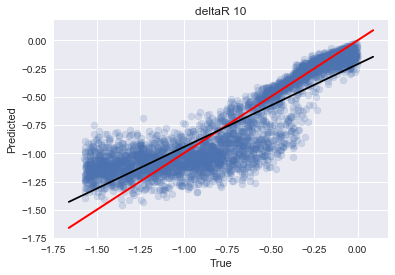

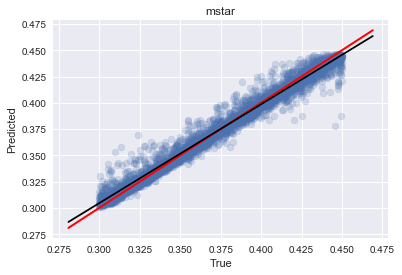

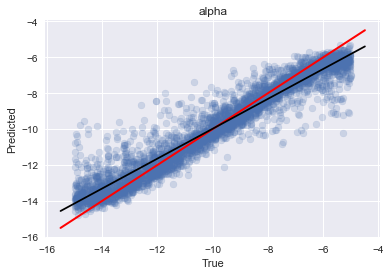

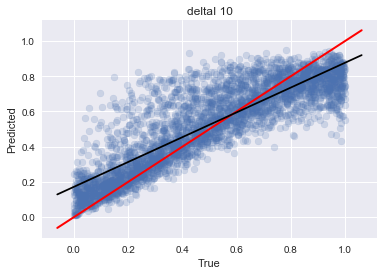

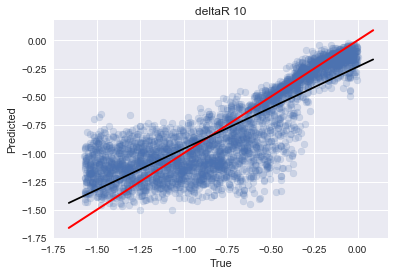

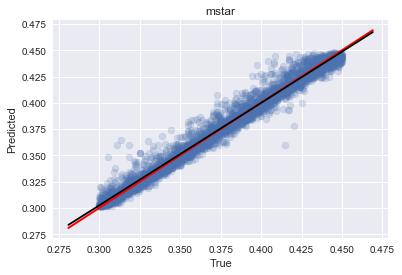

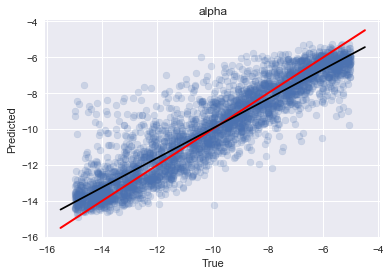

In [8]:
rs = 42
E0_regr_RF_sp = RandomForestRegressor(max_depth = 40, n_estimators = 30, random_state=rs)

E0_model_RF_sp = E0_regr_RF_sp.fit(X3_train, Y3_train)

E0_predictions_RF_sp = E0_model_RF_sp.predict(X3_test)

E0_scores_RF = [r2_score(Y3_test['deltaI'], E0_predictions_RF_sp[:,0]), 
                r2_score(Y3_test['deltaR'], E0_predictions_RF_sp[:,1]), 
                r2_score(Y3_test['mstar'], E0_predictions_RF_sp[:,2]), 
                r2_score(Y3_test['alpha'], E0_predictions_RF_sp[:,3])]

print('')
print('Score - Random Forest:' , E0_model_RF_sp.score(X3_test, Y3_test), 'for delta I/R 10')

plotSummary(Y3_test['deltaI'], E0_predictions_RF_sp[:,0], 'deltaI 10')
plotSummary(Y3_test['deltaR'], E0_predictions_RF_sp[:,1], 'deltaR 10')
plotSummary(Y3_test['mstar'], E0_predictions_RF_sp[:,2], 'mstar')
plotSummary(Y3_test['alpha'], E0_predictions_RF_sp[:,3], 'alpha')

rs = 42
E0_regr_RF_pi = RandomForestRegressor(max_depth = 40, n_estimators = 30, random_state=rs)

E0_model_RF_pi = E0_regr_RF_pi.fit(X4_train, Y4_train)

E0_predictions_RF_pi = E0_model_RF_pi.predict(X4_test)

E0_scores_RF_pi = [r2_score(Y4_test['deltaI'], E0_predictions_RF_pi[:,0]), 
                   r2_score(Y4_test['deltaR'], E0_predictions_RF_pi[:,1]), 
                   r2_score(Y4_test['mstar'], E0_predictions_RF_pi[:,2]), 
                   r2_score(Y4_test['alpha'], E0_predictions_RF_pi[:,3])]

plotSummary(Y4_test['deltaI'], E0_predictions_RF_pi[:,0], 'deltaI 10')
plotSummary(Y4_test['deltaR'], E0_predictions_RF_pi[:,1], 'deltaR 10')
plotSummary(Y4_test['mstar'], E0_predictions_RF_pi[:,2], 'mstar')
plotSummary(Y4_test['alpha'], E0_predictions_RF_pi[:,3], 'alpha')


 
RMSE on test data: 0.18475055848077926 for  deltaI 10
R^2 Score on test data: 0.8310246458998231 for deltaI 10
 
RMSE on test data: 0.11775889278678772 for  deltaR 10
R^2 Score on test data: 0.8348412380554832 for deltaR 10
 
RMSE on test data: 0.005390109559041335 for  mstar
R^2 Score on test data: 0.9847263336204298 for mstar
 
RMSE on test data: 0.8488361669793787 for  alpha
R^2 Score on test data: 0.91273227692228 for alpha
 
RMSE on test data: 0.10298524072148951 for  deltaI 10
R^2 Score on test data: 0.9474948598141953 for deltaI 10
 
RMSE on test data: 0.04433769575101432 for  deltaR 10
R^2 Score on test data: 0.9765868186384715 for deltaR 10
 
RMSE on test data: 0.006114460290864935 for  mstar
R^2 Score on test data: 0.9803453926325497 for mstar
 
RMSE on test data: 1.1528707251661747 for  alpha
R^2 Score on test data: 0.8390217817336114 for alpha


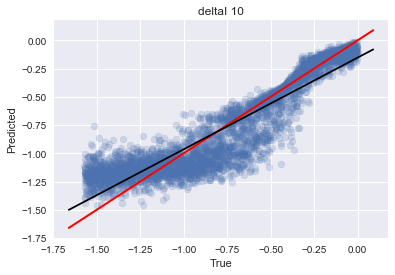

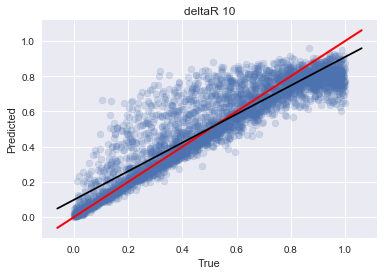

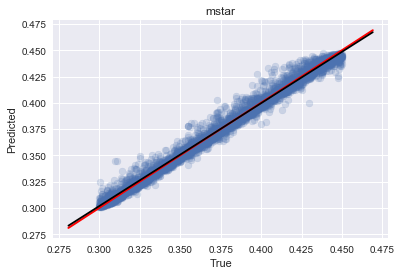

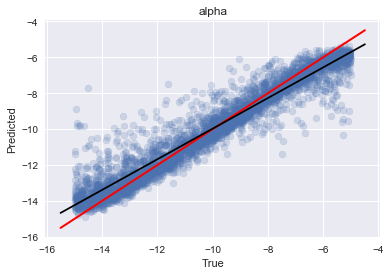

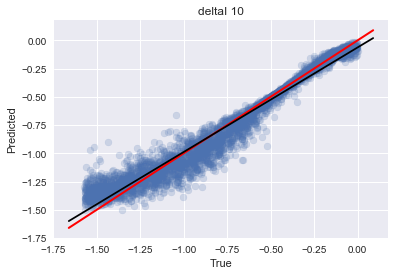

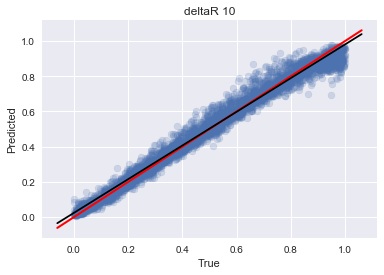

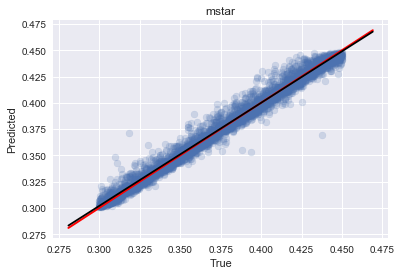

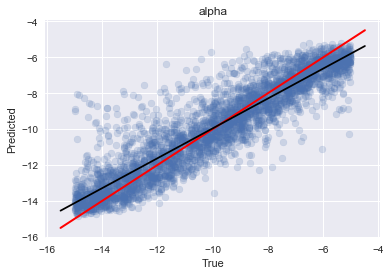

In [10]:
#Trying Independent Random Forest

rs = 42
md = 40
n = 40

E0_regr_RF2_dr_sp = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)
E0_regr_RF2_di_sp = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)
E0_regr_RF2_mstar_sp = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)
E0_regr_RF2_alpha_sp = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)


E0_model_RF2_dr_sp = E0_regr_RF2_dr_sp.fit(X3_train, Y3_train['deltaR'])
E0_model_RF2_di_sp = E0_regr_RF2_di_sp.fit(X3_train, Y3_train['deltaI'])
E0_model_RF2_mstar_sp = E0_regr_RF2_mstar_sp.fit(X3_train, Y3_train['mstar'])
E0_model_RF2_alpha_sp = E0_regr_RF2_alpha_sp.fit(X3_train, Y3_train['alpha'])

E0_predictions_RF2_dr_sp = E0_model_RF2_dr_sp.predict(X3_test)
E0_predictions_RF2_di_sp = E0_model_RF2_di_sp.predict(X3_test)
E0_predictions_RF2_mstar_sp = E0_model_RF2_mstar_sp.predict(X3_test)
E0_predictions_RF2_alpha_sp = E0_model_RF2_alpha_sp.predict(X3_test)

E0_scores_RF2 = [r2_score(Y3_test['deltaI'], E0_predictions_RF2_di_sp), 
              r2_score(Y3_test['deltaR'], E0_predictions_RF2_dr_sp), 
              r2_score(Y3_test['mstar'], E0_predictions_RF2_mstar_sp), 
              r2_score(Y3_test['alpha'], E0_predictions_RF2_alpha_sp)]

#importance_RF_10 = pd.Series(model_RF2.feature_importances_, index = X_train.columns)

plotSummary(Y3_test['deltaR'], E0_predictions_RF2_dr_sp, 'deltaI 10')
plotSummary(Y3_test['deltaI'], E0_predictions_RF2_di_sp, 'deltaR 10')
plotSummary(Y3_test['mstar'], E0_predictions_RF2_mstar_sp, 'mstar')
plotSummary(Y3_test['alpha'], E0_predictions_RF2_alpha_sp, 'alpha')

#Trying Independent Random Forest

rs = 42
md = 30
n = 30

E0_regr_RF2_dr_pi = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)
E0_regr_RF2_di_pi = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)
E0_regr_RF2_mstar_pi = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)
E0_regr_RF2_alpha_pi = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)

E0_model_RF2_dr_pi = E0_regr_RF2_dr_pi.fit(X4_train, Y4_train['deltaR'])
E0_model_RF2_di_pi = E0_regr_RF2_di_pi.fit(X4_train, Y4_train['deltaI'])
E0_model_RF2_mstar_pi = E0_regr_RF2_mstar_pi.fit(X4_train, Y4_train['mstar'])
E0_model_RF2_alpha_pi = E0_regr_RF2_alpha_pi.fit(X4_train, Y4_train['alpha'])

E0_predictions_RF2_dr_pi = E0_model_RF2_dr_pi.predict(X4_test)
E0_predictions_RF2_di_pi = E0_model_RF2_di_pi.predict(X4_test)
E0_predictions_RF2_mstar_pi = E0_model_RF2_mstar_pi.predict(X4_test)
E0_predictions_RF2_alpha_pi = E0_model_RF2_alpha_pi.predict(X4_test)

E0_scores_RF2_pi = [r2_score(Y4_test['deltaI'], E0_predictions_RF2_di_pi), 
                 r2_score(Y4_test['deltaR'], E0_predictions_RF2_dr_pi), 
                 r2_score(Y4_test['mstar'], E0_predictions_RF2_mstar_pi), 
                 r2_score(Y4_test['alpha'], E0_predictions_RF2_alpha_pi)]

plotSummary(Y4_test['deltaR'], E0_predictions_RF2_dr_pi, 'deltaI 10')
plotSummary(Y4_test['deltaI'], E0_predictions_RF2_di_pi, 'deltaR 10')
plotSummary(Y4_test['mstar'], E0_predictions_RF2_mstar_pi, 'mstar')
plotSummary(Y4_test['alpha'], E0_predictions_RF2_alpha_pi, 'alpha')




 
RMSE on test data: 0.1195247122057366 for  AdaBoost Delta I
R^2 Score on test data: 0.8298509201635482 for AdaBoost Delta I
 
RMSE on test data: 0.1867004891892801 for  AdaBoost Delta R
R^2 Score on test data: 0.8274389569580091 for AdaBoost Delta R
 
RMSE on test data: 0.005378170630878838 for  AdaBoost mstar
R^2 Score on test data: 0.9847939200961817 for AdaBoost mstar
 
RMSE on test data: 0.8620656606417297 for  AdaBoost alpha
R^2 Score on test data: 0.9099908655725397 for AdaBoost alpha
 
RMSE on test data: 0.04597091079129381 for  AdaBoost Delta I
R^2 Score on test data: 0.9748301627196897 for AdaBoost Delta I
 
RMSE on test data: 0.10140778633020339 for  AdaBoost Delta R
R^2 Score on test data: 0.9490910136003526 for AdaBoost Delta R
 
RMSE on test data: 0.006047129566508348 for  AdaBoost mstar
R^2 Score on test data: 0.9807758714186763 for AdaBoost mstar
 
RMSE on test data: 1.232798126916362 for  AdaBoost alpha
R^2 Score on test data: 0.8159271123544433 for AdaBoost alpha


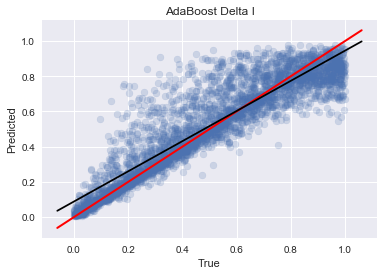

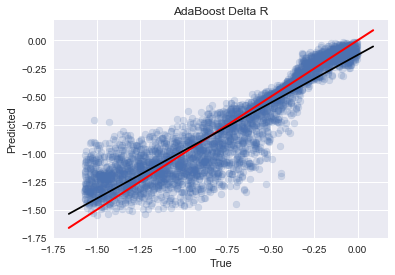

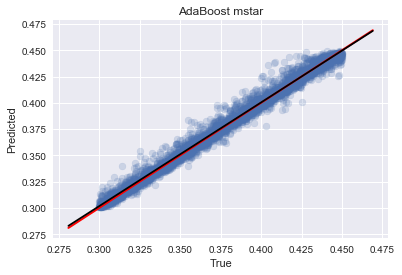

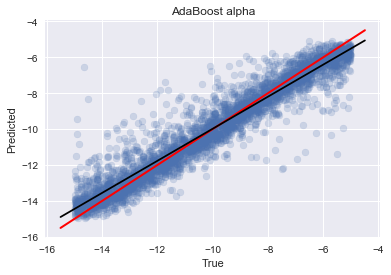

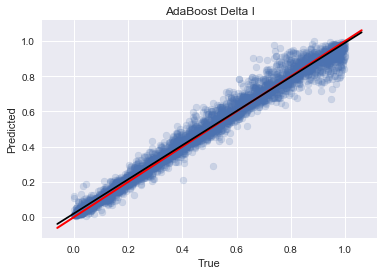

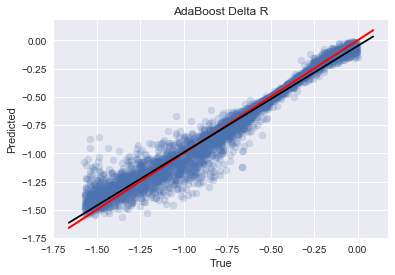

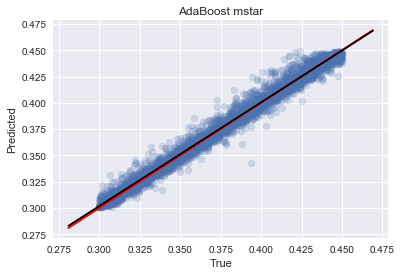

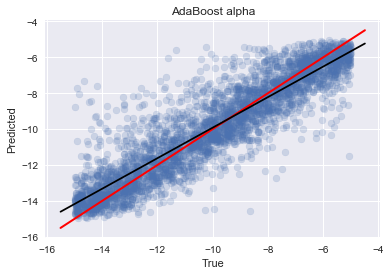

In [11]:
#Using AdaBoost Regression

from sklearn.ensemble import AdaBoostRegressor

rng = 42
md = 30
nest2 = 15

E0_regr_AB_di_sp = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md), n_estimators=nest2, random_state=rng)
E0_regr_AB_dr_sp = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md),n_estimators=nest2, random_state=rng)
E0_regr_AB_mstar_sp = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md), n_estimators = nest2, random_state = rng)
E0_regr_AB_alpha_sp = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md), n_estimators = nest2, random_state = rng)

E0_model_AB_di_sp = E0_regr_AB_di_sp.fit(X3_train, Y3_train['deltaI'])
E0_model_AB_dr_sp = E0_regr_AB_dr_sp.fit(X3_train, Y3_train['deltaR'])
E0_model_AB_mstar_sp = E0_regr_AB_mstar_sp.fit(X3_train, Y3_train['mstar'])
E0_model_AB_alpha_sp = E0_regr_AB_alpha_sp.fit(X3_train, Y3_train['alpha'])

E0_predictions_AB_di_sp = E0_model_AB_di_sp.predict(X3_test)
E0_predictions_AB_dr_sp = E0_model_AB_dr_sp.predict(X3_test)
E0_predictions_AB_mstar_sp = E0_model_AB_mstar_sp.predict(X3_test)
E0_predictions_AB_alpha_sp = E0_model_AB_alpha_sp.predict(X3_test)

E0_scores_AB = [r2_score(Y3_test['deltaI'], E0_predictions_AB_di_sp), 
             r2_score(Y3_test['deltaR'], E0_predictions_AB_dr_sp), 
             r2_score(Y3_test['mstar'], E0_predictions_AB_mstar_sp), 
             r2_score(Y3_test['alpha'], E0_predictions_AB_alpha_sp)]

plotSummary(Y3_test['deltaI'], E0_predictions_AB_di_sp, 'AdaBoost Delta I')
plotSummary(Y3_test['deltaR'], E0_predictions_AB_dr_sp, 'AdaBoost Delta R')
plotSummary(Y3_test['mstar'], E0_predictions_AB_mstar_sp, 'AdaBoost mstar')
plotSummary(Y3_test['alpha'], E0_predictions_AB_alpha_sp, 'AdaBoost alpha')

#Using AdaBoost Regression

from sklearn.ensemble import AdaBoostRegressor

rng = 42
md = 30
nest2 = 15

E0_regr_AB_di_pi = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md), n_estimators=nest2, random_state=rng)
E0_regr_AB_dr_pi = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md),n_estimators=nest2, random_state=rng)
E0_regr_AB_mstar_pi = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md), n_estimators = nest2, random_state = rng)
E0_regr_AB_alpha_pi = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md), n_estimators = nest2, random_state = rng)

E0_model_AB_di_pi = E0_regr_AB_di_pi.fit(X4_train, Y4_train['deltaI'])
E0_model_AB_dr_pi = E0_regr_AB_dr_pi.fit(X4_train, Y4_train['deltaR'])
E0_model_AB_mstar_pi = E0_regr_AB_mstar_pi.fit(X4_train, Y4_train['mstar'])
E0_model_AB_alpha_pi = E0_regr_AB_alpha_pi.fit(X4_train, Y4_train['alpha'])

E0_predictions_AB_di_pi = E0_model_AB_di_pi.predict(X4_test)
E0_predictions_AB_dr_pi = E0_model_AB_dr_pi.predict(X4_test)
E0_predictions_AB_mstar_pi = E0_model_AB_mstar_pi.predict(X4_test)
E0_predictions_AB_alpha_pi = E0_model_AB_alpha_pi.predict(X4_test)

E0_scores_AB_pi = [r2_score(Y4_test['deltaI'], E0_predictions_AB_di_pi), 
                r2_score(Y4_test['deltaR'], E0_predictions_AB_dr_pi), 
                r2_score(Y4_test['mstar'], E0_predictions_AB_mstar_pi), 
                r2_score(Y4_test['alpha'], E0_predictions_AB_alpha_pi)]

plotSummary(Y4_test['deltaI'], E0_predictions_AB_di_pi, 'AdaBoost Delta I')
plotSummary(Y4_test['deltaR'], E0_predictions_AB_dr_pi, 'AdaBoost Delta R')
plotSummary(Y4_test['mstar'], E0_predictions_AB_mstar_pi, 'AdaBoost mstar')
plotSummary(Y4_test['alpha'], E0_predictions_AB_alpha_pi, 'AdaBoost alpha')




 
RMSE on test data: 0.15344413285255307 for  GradientBoost Delta I
R^2 Score on test data: 0.7195762672648268 for GradientBoost Delta I
 
RMSE on test data: 0.24202096756589764 for  GradientBoost Delta R
R^2 Score on test data: 0.7100268201031424 for GradientBoost Delta R
 
RMSE on test data: 0.00670021112090661 for  GradientBoost mstar
R^2 Score on test data: 0.9763992888586418 for GradientBoost mstar
 
RMSE on test data: 1.2518206362046507 for  GradientBoost alpha
R^2 Score on test data: 0.8102026664054846 for GradientBoost alpha
 
RMSE on test data: 0.06024703107010247 for  GradientBoost Delta I
R^2 Score on test data: 0.956769974514359 for GradientBoost Delta I
 
RMSE on test data: 0.12789142094804884 for  GradientBoost Delta R
R^2 Score on test data: 0.9190280364866653 for GradientBoost Delta R
 
RMSE on test data: 0.0073719129409773295 for  GradientBoost mstar
R^2 Score on test data: 0.9714301138192897 for GradientBoost mstar
 
RMSE on test data: 1.4389538256688392 for  Gradient

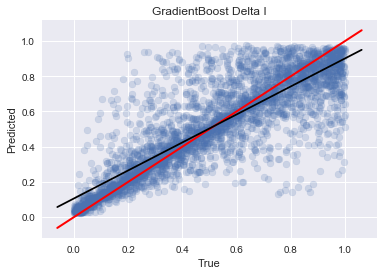

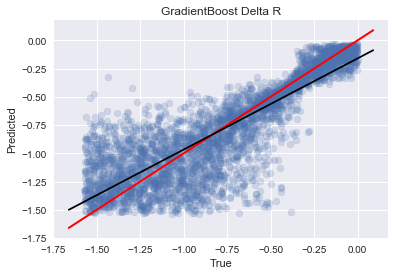

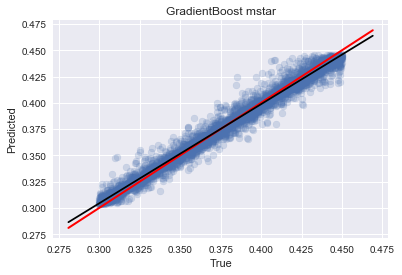

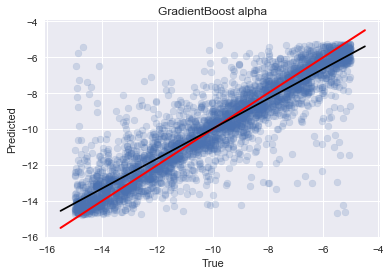

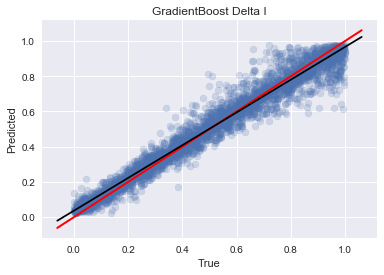

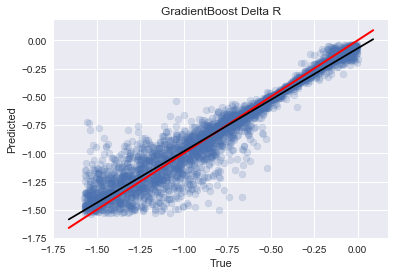

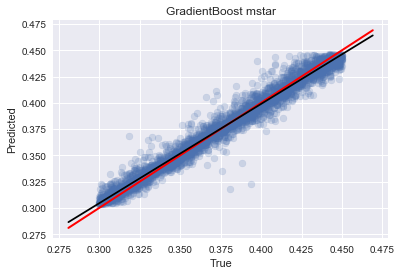

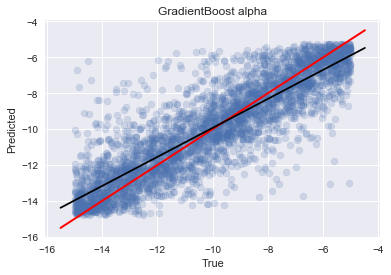

In [12]:
# Using Gradient Boosting Regression

from sklearn.ensemble import GradientBoostingRegressor

rng = 42

md = 50
nest2 = 30


E0_regr_GB_di_sp = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)
E0_regr_GB_dr_sp = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)
E0_regr_GB_mstar_sp = GradientBoostingRegressor(max_depth = md, n_estimators = nest2, random_state = rng)
E0_regr_GB_alpha_sp = GradientBoostingRegressor(max_depth = md, n_estimators = nest2, random_state = rng)

E0_model_GB_di_sp = E0_regr_GB_di_sp.fit(X3_train, Y3_train['deltaI'])
E0_model_GB_dr_sp = E0_regr_GB_dr_sp.fit(X3_train, Y3_train['deltaR'])
E0_model_GB_mstar_sp = E0_regr_GB_mstar_sp.fit(X3_train, Y3_train['mstar'])
E0_model_GB_alpha_sp = E0_regr_GB_alpha_sp.fit(X3_train, Y3_train['alpha'])


E0_predictions_GB_di_sp = E0_model_GB_di_sp.predict(X3_test)
E0_predictions_GB_dr_sp = E0_model_GB_dr_sp.predict(X3_test)
E0_predictions_GB_mstar_sp = E0_model_GB_mstar_sp.predict(X3_test)
E0_predictions_GB_alpha_sp = E0_model_GB_alpha_sp.predict(X3_test)

E0_scores_GB = [r2_score(Y3_test['deltaI'], E0_predictions_GB_di_sp), 
                r2_score(Y3_test['deltaR'], E0_predictions_GB_dr_sp), 
                r2_score(Y3_test['mstar'], E0_predictions_GB_mstar_sp), 
                r2_score(Y3_test['alpha'], E0_predictions_GB_alpha_sp)]

plotSummary(Y3_test['deltaI'], E0_predictions_GB_di_sp, 'GradientBoost Delta I')
plotSummary(Y3_test['deltaR'], E0_predictions_GB_dr_sp, 'GradientBoost Delta R')
plotSummary(Y3_test['mstar'], E0_predictions_GB_mstar_sp, 'GradientBoost mstar')
plotSummary(Y3_test['alpha'], E0_predictions_GB_alpha_sp, 'GradientBoost alpha')


# Using Gradient Boosting Regression

from sklearn.ensemble import GradientBoostingRegressor

rng = 42

md = 50
nest2 = 30


E0_regr_GB_di_pi = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)
E0_regr_GB_dr_pi = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)
E0_regr_GB_mstar_pi = GradientBoostingRegressor(max_depth = md, n_estimators = nest2, random_state = rng)
E0_regr_GB_alpha_pi = GradientBoostingRegressor(max_depth = md, n_estimators = nest2, random_state = rng)

E0_model_GB_di_pi = E0_regr_GB_di_pi.fit(X4_train, Y4_train['deltaI'])
E0_model_GB_dr_pi = E0_regr_GB_dr_pi.fit(X4_train, Y4_train['deltaR'])
E0_model_GB_mstar_pi = E0_regr_GB_mstar_pi.fit(X4_train, Y4_train['mstar'])
E0_model_GB_alpha_pi = E0_regr_GB_alpha_pi.fit(X4_train, Y4_train['alpha'])

E0_predictions_GB_di_pi = E0_model_GB_di_pi.predict(X4_test)
E0_predictions_GB_dr_pi = E0_model_GB_dr_pi.predict(X4_test)
E0_predictions_GB_mstar_pi = E0_model_GB_mstar_pi.predict(X4_test)
E0_predictions_GB_alpha_pi = E0_model_GB_alpha_pi.predict(X4_test)

E0_scores_GB_pi = [r2_score(Y4_test['deltaI'], E0_predictions_GB_di_pi), 
                r2_score(Y4_test['deltaR'], E0_predictions_GB_dr_pi), 
                r2_score(Y4_test['mstar'], E0_predictions_GB_mstar_pi), 
                r2_score(Y4_test['alpha'], E0_predictions_GB_alpha_pi)]

plotSummary(Y4_test['deltaI'], E0_predictions_GB_di_pi, 'GradientBoost Delta I')
plotSummary(Y4_test['deltaR'], E0_predictions_GB_dr_pi, 'GradientBoost Delta R')
plotSummary(Y4_test['mstar'], E0_predictions_GB_mstar_pi, 'GradientBoost mstar')
plotSummary(Y4_test['alpha'], E0_predictions_GB_alpha_pi, 'GradientBoost alpha')



In [18]:
# Load the experimental data
col_names3 = peak_names + locs_names + width_names + prom_names
col_names4 = energy_names

exp_data_sp = pd.read_csv('Training_Data/Hexagon/HexagonExperimentalData062218_v8_specPoints.csv', header = None, names = col_names4)
exp_data_pi = pd.read_csv('Training_Data/Hexagon/HexagonExperimentalData062218_v8_peakinfo.csv', header = None, names = col_names3)

E0_pred_phase_OLS_R_sp = E0_results_OLS_R_sp.predict(exp_data_sp)
E0_pred_phase_OLS_I_sp = E0_results_OLS_I_sp.predict(exp_data_sp)
E0_pred_phase_OLS_mstar_sp = E0_results_OLS_mstar_sp.predict(exp_data_sp)
E0_pred_phase_OLS_alpha_sp = E0_results_OLS_alpha_sp.predict(exp_data_sp)

E0_pred_phase_OLS_R_pi = E0_results_OLS_R_pi.predict(exp_data_pi)
E0_pred_phase_OLS_I_pi = E0_results_OLS_I_pi.predict(exp_data_pi)
E0_pred_phase_OLS_mstar_pi = E0_results_OLS_mstar_pi.predict(exp_data_pi)
E0_pred_phase_OLS_alpha_pi = E0_results_OLS_alpha_pi.predict(exp_data_pi)

E0_phases_OLS_sp = [E0_pred_phase_OLS_I_sp[0], 
                    E0_pred_phase_OLS_R_pi[0], 
                    E0_pred_phase_OLS_mstar_sp[0], 
                    E0_pred_phase_OLS_alpha_sp[0]]
E0_phases_OLS_pi = [E0_pred_phase_OLS_I_pi[0], 
                    E0_pred_phase_OLS_R_pi[0], 
                    E0_pred_phase_OLS_mstar_pi[0], 
                    E0_pred_phase_OLS_alpha_pi[0]]

#pred_phase_DT_sp = np.append(regr_DT_sp.predict(exp_data_sp),r2_score(Y1_test['deltaI'], predictions_DT_sp[:,0])).reshape(3,1).T
#pred_phase_DT_sp = np.append(pred_phase_DT_sp, r2_score(Y1_test['deltaR'], predictions_DT_sp[:,1])).reshape(4,1).T
#pred_phase_DT = np.append(pred_phase_DT, r2_score(Y_test['scale_factor'], y_pred_DT[:,2]))
E0_phases_DT_sp = E0_regr_DT_sp.predict(exp_data_sp)
E0_phases_DT_pi = E0_regr_DT_pi.predict(exp_data_pi)

E0_phases_RF_sp = E0_regr_RF_sp.predict(exp_data_sp)
E0_phases_RF_pi = E0_regr_RF_pi.predict(exp_data_pi)

E0_pred_phase_AB_R_sp = E0_model_AB_dr_sp.predict(exp_data_sp)
E0_pred_phase_AB_I_sp = E0_model_AB_di_sp.predict(exp_data_sp)
E0_pred_phase_AB_mstar_sp = E0_model_AB_mstar_sp.predict(exp_data_sp)
E0_pred_phase_AB_alpha_sp = E0_model_AB_alpha_sp.predict(exp_data_sp)

E0_pred_phase_AB_R_pi = E0_model_AB_dr_pi.predict(exp_data_pi)
E0_pred_phase_AB_I_pi = E0_model_AB_di_pi.predict(exp_data_pi)
E0_pred_phase_AB_mstar_pi = E0_model_AB_mstar_pi.predict(exp_data_pi)
E0_pred_phase_AB_alpha_pi = E0_model_AB_alpha_pi.predict(exp_data_pi)

E0_phases_AB_sp = [E0_pred_phase_AB_I_sp[0], 
                   E0_pred_phase_AB_R_sp[0], 
                   E0_pred_phase_AB_mstar_sp[0], 
                   E0_pred_phase_AB_alpha_sp[0]]

E0_phases_AB_pi = [E0_pred_phase_AB_I_pi[0], 
                   E0_pred_phase_AB_R_pi[0], 
                   E0_pred_phase_AB_mstar_pi[0], 
                   E0_pred_phase_AB_alpha_pi[0]]

E0_pred_phase_GB_di_sp = E0_model_GB_di_sp.predict(exp_data_sp)
E0_pred_phase_GB_dr_sp = E0_model_GB_dr_sp.predict(exp_data_sp)
E0_pred_phase_GB_mstar_sp = E0_model_GB_mstar_sp.predict(exp_data_sp)
E0_pred_phase_GB_alpha_sp = E0_model_GB_alpha_sp.predict(exp_data_sp)

E0_pred_phase_GB_di_pi = E0_model_GB_di_pi.predict(exp_data_pi)
E0_pred_phase_GB_dr_pi = E0_model_GB_dr_pi.predict(exp_data_pi)
E0_pred_phase_GB_mstar_pi = E0_model_GB_mstar_pi.predict(exp_data_pi)
E0_pred_phase_GB_alpha_pi = E0_model_GB_alpha_pi.predict(exp_data_pi)

E0_phases_GB_sp = [E0_pred_phase_GB_di_sp[0], 
                   E0_pred_phase_GB_dr_sp[0], 
                   E0_pred_phase_GB_mstar_sp[0], 
                   E0_pred_phase_GB_alpha_sp[0]]

E0_phases_GB_pi = [E0_pred_phase_GB_di_pi[0], 
                   E0_pred_phase_GB_dr_pi[0], 
                   E0_pred_phase_GB_mstar_pi[0], 
                   E0_pred_phase_GB_alpha_pi[0]]

E0_pred_phase_IRF_di_sp = E0_model_RF2_di_sp.predict(exp_data_sp)
E0_pred_phase_IRF_dr_sp = E0_model_RF2_dr_sp.predict(exp_data_sp)
E0_pred_phase_IRF_mstar_sp = E0_model_RF2_mstar_sp.predict(exp_data_sp)
E0_pred_phase_IRF_alpha_sp = E0_model_RF2_alpha_sp.predict(exp_data_sp)

E0_pred_phase_IRF_di_pi = E0_model_RF2_di_pi.predict(exp_data_pi)
E0_pred_phase_IRF_dr_pi = E0_model_RF2_dr_pi.predict(exp_data_pi)
E0_pred_phase_IRF_mstar_pi = E0_model_RF2_mstar_pi.predict(exp_data_pi)
E0_pred_phase_IRF_alpha_pi = E0_model_RF2_alpha_pi.predict(exp_data_pi)

E0_phases_IRF_sp = [E0_pred_phase_IRF_di_sp[0], 
                    E0_pred_phase_IRF_dr_sp[0], 
                    E0_pred_phase_IRF_mstar_sp[0], 
                    E0_pred_phase_IRF_alpha_sp[0]]

E0_phases_IRF_pi = [E0_pred_phase_IRF_di_pi[0], 
                    E0_pred_phase_IRF_dr_pi[0], 
                    E0_pred_phase_IRF_mstar_pi[0], 
                    E0_pred_phase_IRF_alpha_pi[0]]

E0_predictedPhases = pd.DataFrame([], columns = ['deltaI', 'deltaR', 'mstar', 'alpha'])

E0_predictedPhases.loc['OLS_sp'] = E0_phases_OLS_sp
E0_predictedPhases.loc['OLS_pi'] = E0_phases_OLS_pi
E0_predictedPhases.loc['DT_sp'] = E0_phases_DT_sp.tolist()[0]
E0_predictedPhases.loc['DT_pi'] = E0_phases_DT_pi.tolist()[0]
E0_predictedPhases.loc['RF_sp'] = E0_phases_RF_sp.tolist()[0]
E0_predictedPhases.loc['RF_pi'] = E0_phases_RF_pi.tolist()[0]
E0_predictedPhases.loc['IRF_sp'] = E0_phases_IRF_sp
E0_predictedPhases.loc['IRF_pi'] = E0_phases_IRF_pi
E0_predictedPhases.loc['AB_sp'] = E0_phases_AB_sp
E0_predictedPhases.loc['AB_pi'] = E0_phases_AB_pi
E0_predictedPhases.loc['GB_sp'] = E0_phases_GB_sp
E0_predictedPhases.loc['GB_pi'] = E0_phases_GB_pi

E0_Scores = pd.DataFrame([], columns = ['deltaI', 'deltaR', 'mstar', 'alpha'])

E0_Scores.loc['OLS_sp'] = E0_scores_OLS
E0_Scores.loc['OLS_pi'] = E0_scores_OLS_pi
E0_Scores.loc['DT_sp'] = E0_scores_DT
E0_Scores.loc['DT_pi'] = E0_scores_DT_pi
E0_Scores.loc['RF_sp'] = E0_scores_RF
E0_Scores.loc['RF_pi'] = E0_scores_RF_pi
E0_Scores.loc['IRF_sp'] = E0_scores_RF2
E0_Scores.loc['IRF_pi'] = E0_scores_RF2_pi
E0_Scores.loc['AB_sp'] = E0_scores_AB
E0_Scores.loc['AB_pi'] = E0_scores_AB_pi
E0_Scores.loc['GB_sp'] = E0_scores_GB
E0_Scores.loc['GB_pi'] = E0_scores_GB_pi

E0_predictedPhases

,deltaI,deltaR,mstar,alpha
OLS_sp,0.385604,-0.961001,0.251750,-38.550054
OLS_pi,0.333968,-0.961001,0.417784,-21.259677
DT_sp,0.195190,-0.096087,0.369655,-14.075500
DT_pi,0.354140,-0.261041,0.382623,-10.207800
RF_sp,0.219873,-0.073370,0.377314,-10.797540
RF_pi,0.350389,-0.082835,0.377214,-11.457453
IRF_sp,0.123509,-0.053325,0.380462,-10.579205
IRF_pi,0.256318,-0.019843,0.376945,-11.314993
AB_sp,0.107930,-0.031166,0.373290,-12.059000
AB_pi,0.282210,-0.017616,0.378525,-11.534000


In [19]:
score_threshold = 0.95

avgmstar = E0_predictedPhases[E0_Scores > score_threshold]['mstar'].mean()

avgmstar

0.37712757913372286

In [20]:
E0_Scores

,deltaI,deltaR,mstar,alpha
OLS_sp,-69.645872,-20.503855,-0.914437,-110.140016
OLS_pi,0.637440,0.552634,0.862695,0.169894
DT_sp,0.472905,0.541127,0.904789,0.768809
DT_pi,0.522737,0.529195,0.953008,0.718820
RF_sp,0.748724,0.753346,0.972093,0.906704
RF_pi,0.731101,0.699641,0.974630,0.837248
IRF_sp,0.834841,0.831025,0.984726,0.912732
IRF_pi,0.976587,0.947495,0.980345,0.839022
AB_sp,0.829851,0.827439,0.984794,0.909991
AB_pi,0.974830,0.949091,0.980776,0.815927


In [21]:
E0_predictedPhases[E0_Scores > score_threshold]

,deltaI,deltaR,mstar,alpha
OLS_sp,NaN,NaN,NaN,NaN
OLS_pi,NaN,NaN,NaN,NaN
DT_sp,NaN,NaN,NaN,NaN
DT_pi,NaN,NaN,0.382623,NaN
RF_sp,NaN,NaN,0.377314,NaN
RF_pi,NaN,NaN,0.377214,NaN
IRF_sp,NaN,NaN,0.380462,NaN
IRF_pi,0.256318,NaN,0.376945,NaN
AB_sp,NaN,NaN,0.373290,NaN
AB_pi,0.282210,NaN,0.378525,NaN
